# 1.4c: Cluster Telescope View

This notebook visualizes the cluster using the telescope, automatically centered on the cluster centroid.

## The Question

We've identified 2,251 tokens that are indistinguishable at bfloat16 precision (all share cosine = 0.84375 to a reference direction).

But what does the cluster look like at **sub-bfloat16 scale**? In float32 coordinate space, can we see internal structure that's invisible to the model?

## Approach

1. Load cluster membership from 1.4a
2. Compute cluster centroid in lat/long coordinates
3. Point telescope at cluster centroid
4. Plot cluster tokens (red) vs non-cluster tokens (blue)
5. Zoom to see sub-bfloat16 structure

## Parameters

In [64]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis (same as 1.3c)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Telescope field of view
ANGULAR_DIAMETER = 0.1  # Degrees (adjustable)

# Visualization
CLUSTER_COLOR = 'red'
NON_CLUSTER_COLOR = 'steelblue'
CLUSTER_SIZE = 10
NON_CLUSTER_SIZE = 10
CLUSTER_ALPHA = 0.5
NON_CLUSTER_ALPHA = 0.5
FIGSIZE = (12, 10)
DPI = 200

# Density heatmap
ANGULAR_BIN_SIZE = 1  # Very fine bins to see sub-bfloat16 structure
DENSITY_SMOOTH = 0.5
DENSITY_COLORMAP = 'hot'

## Imports

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from safetensors.torch import load_file
from pathlib import Path

## Load Cluster Membership

In [66]:
# Load cluster data
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4a_cluster_members.safetensors")
cluster_data = load_file(cluster_path)

cluster_mask = cluster_data["cluster_mask"].bool()
n_cluster = cluster_data["n_cluster_members"].item()
cluster_cosine = cluster_data["cluster_cosine"].item()

print(f"Loaded cluster membership:")
print(f"  Cluster size: {n_cluster:,} tokens")
print(f"  Cluster cosine: {cluster_cosine:.8f}")

Loaded cluster membership:
  Cluster size: 2,251 tokens
  Cluster cosine: 0.84375000


## Load W and Compute PCA

In [67]:
# Load W
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]
W = W_bf16.to(torch.float32)
N, d = W.shape

print(f"\nLoaded W: {N:,} tokens × {d:,} dimensions")

# Compute PCA
print("\nComputing PCA...")
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, idx]
print("✓ PCA computed")


Loaded W: 151,936 tokens × 2,560 dimensions

Computing PCA...
✓ PCA computed


## Define Spherical Basis and Compute Coordinates

In [68]:
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

# Extract basis
north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

# Project to spherical coordinates
print("\nProjecting to spherical coordinates...")
x = W @ meridian
y = W @ equinox
z = W @ north
r = torch.sqrt(x**2 + y**2 + z**2)

lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)

lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print("✓ Spherical coordinates computed")


Projecting to spherical coordinates...
✓ Spherical coordinates computed


## Compute Cluster Centroid

We compute the centroid of cluster tokens in lat/long space.

In [69]:
print("\nComputing cluster centroid...\n")

# Extract cluster coordinates
cluster_lat = lat_deg[cluster_mask]
cluster_lon = lon_deg[cluster_mask]

# Compute centroid (mean of cluster positions)
centroid_lat = cluster_lat.mean().item()
centroid_lon = cluster_lon.mean().item()

print(f"Cluster centroid:")
print(f"  Latitude: {centroid_lat:.6f}°")
print(f"  Longitude: {centroid_lon:.6f}°")
print()
print(f"Cluster extent:")
print(f"  Lat range: [{cluster_lat.min():.6f}°, {cluster_lat.max():.6f}°]")
print(f"  Lon range: [{cluster_lon.min():.6f}°, {cluster_lon.max():.6f}°]")
print(f"  Lat span: {(cluster_lat.max() - cluster_lat.min()).item():.6f}°")
print(f"  Lon span: {(cluster_lon.max() - cluster_lon.min()).item():.6f}°")


Computing cluster centroid...

Cluster centroid:
  Latitude: -7.283405°
  Longitude: 6.936738°

Cluster extent:
  Lat range: [-7.569002°, -5.335981°]
  Lon range: [6.188617°, 7.194351°]
  Lat span: 2.233021°
  Lon span: 1.005734°


## Filter Tokens to Telescope Field of View

In [70]:
print(f"\nFiltering to telescope field of view...")
print(f"  Center: ({centroid_lat:.6f}°, {centroid_lon:.6f}°)")
print(f"  Angular diameter: {ANGULAR_DIAMETER}°")
print()

# Define region bounds
half_width = ANGULAR_DIAMETER / 2
lat_min = centroid_lat - half_width
lat_max = centroid_lat + half_width
lon_min = centroid_lon - half_width
lon_max = centroid_lon + half_width

# Filter tokens in field of view
in_fov = (
    (lat_deg >= lat_min) & (lat_deg <= lat_max) &
    (lon_deg >= lon_min) & (lon_deg <= lon_max)
)

# Separate cluster vs non-cluster in FOV
cluster_in_fov = in_fov & cluster_mask
non_cluster_in_fov = in_fov & ~cluster_mask

n_cluster_fov = cluster_in_fov.sum().item()
n_non_cluster_fov = non_cluster_in_fov.sum().item()
n_total_fov = in_fov.sum().item()

print(f"✓ Filtered to field of view")
print(f"  Total tokens in FOV: {n_total_fov:,}")
print(f"  Cluster tokens: {n_cluster_fov:,} ({n_cluster_fov/n_total_fov*100:.1f}%)")
print(f"  Non-cluster tokens: {n_non_cluster_fov:,} ({n_non_cluster_fov/n_total_fov*100:.1f}%)")


Filtering to telescope field of view...
  Center: (-7.283405°, 6.936738°)
  Angular diameter: 0.1°

✓ Filtered to field of view
  Total tokens in FOV: 2,215
  Cluster tokens: 2,213 (99.9%)
  Non-cluster tokens: 2 (0.1%)


## Rectangular Scatter Plot: Two Colors


Creating two-color scatter plot...



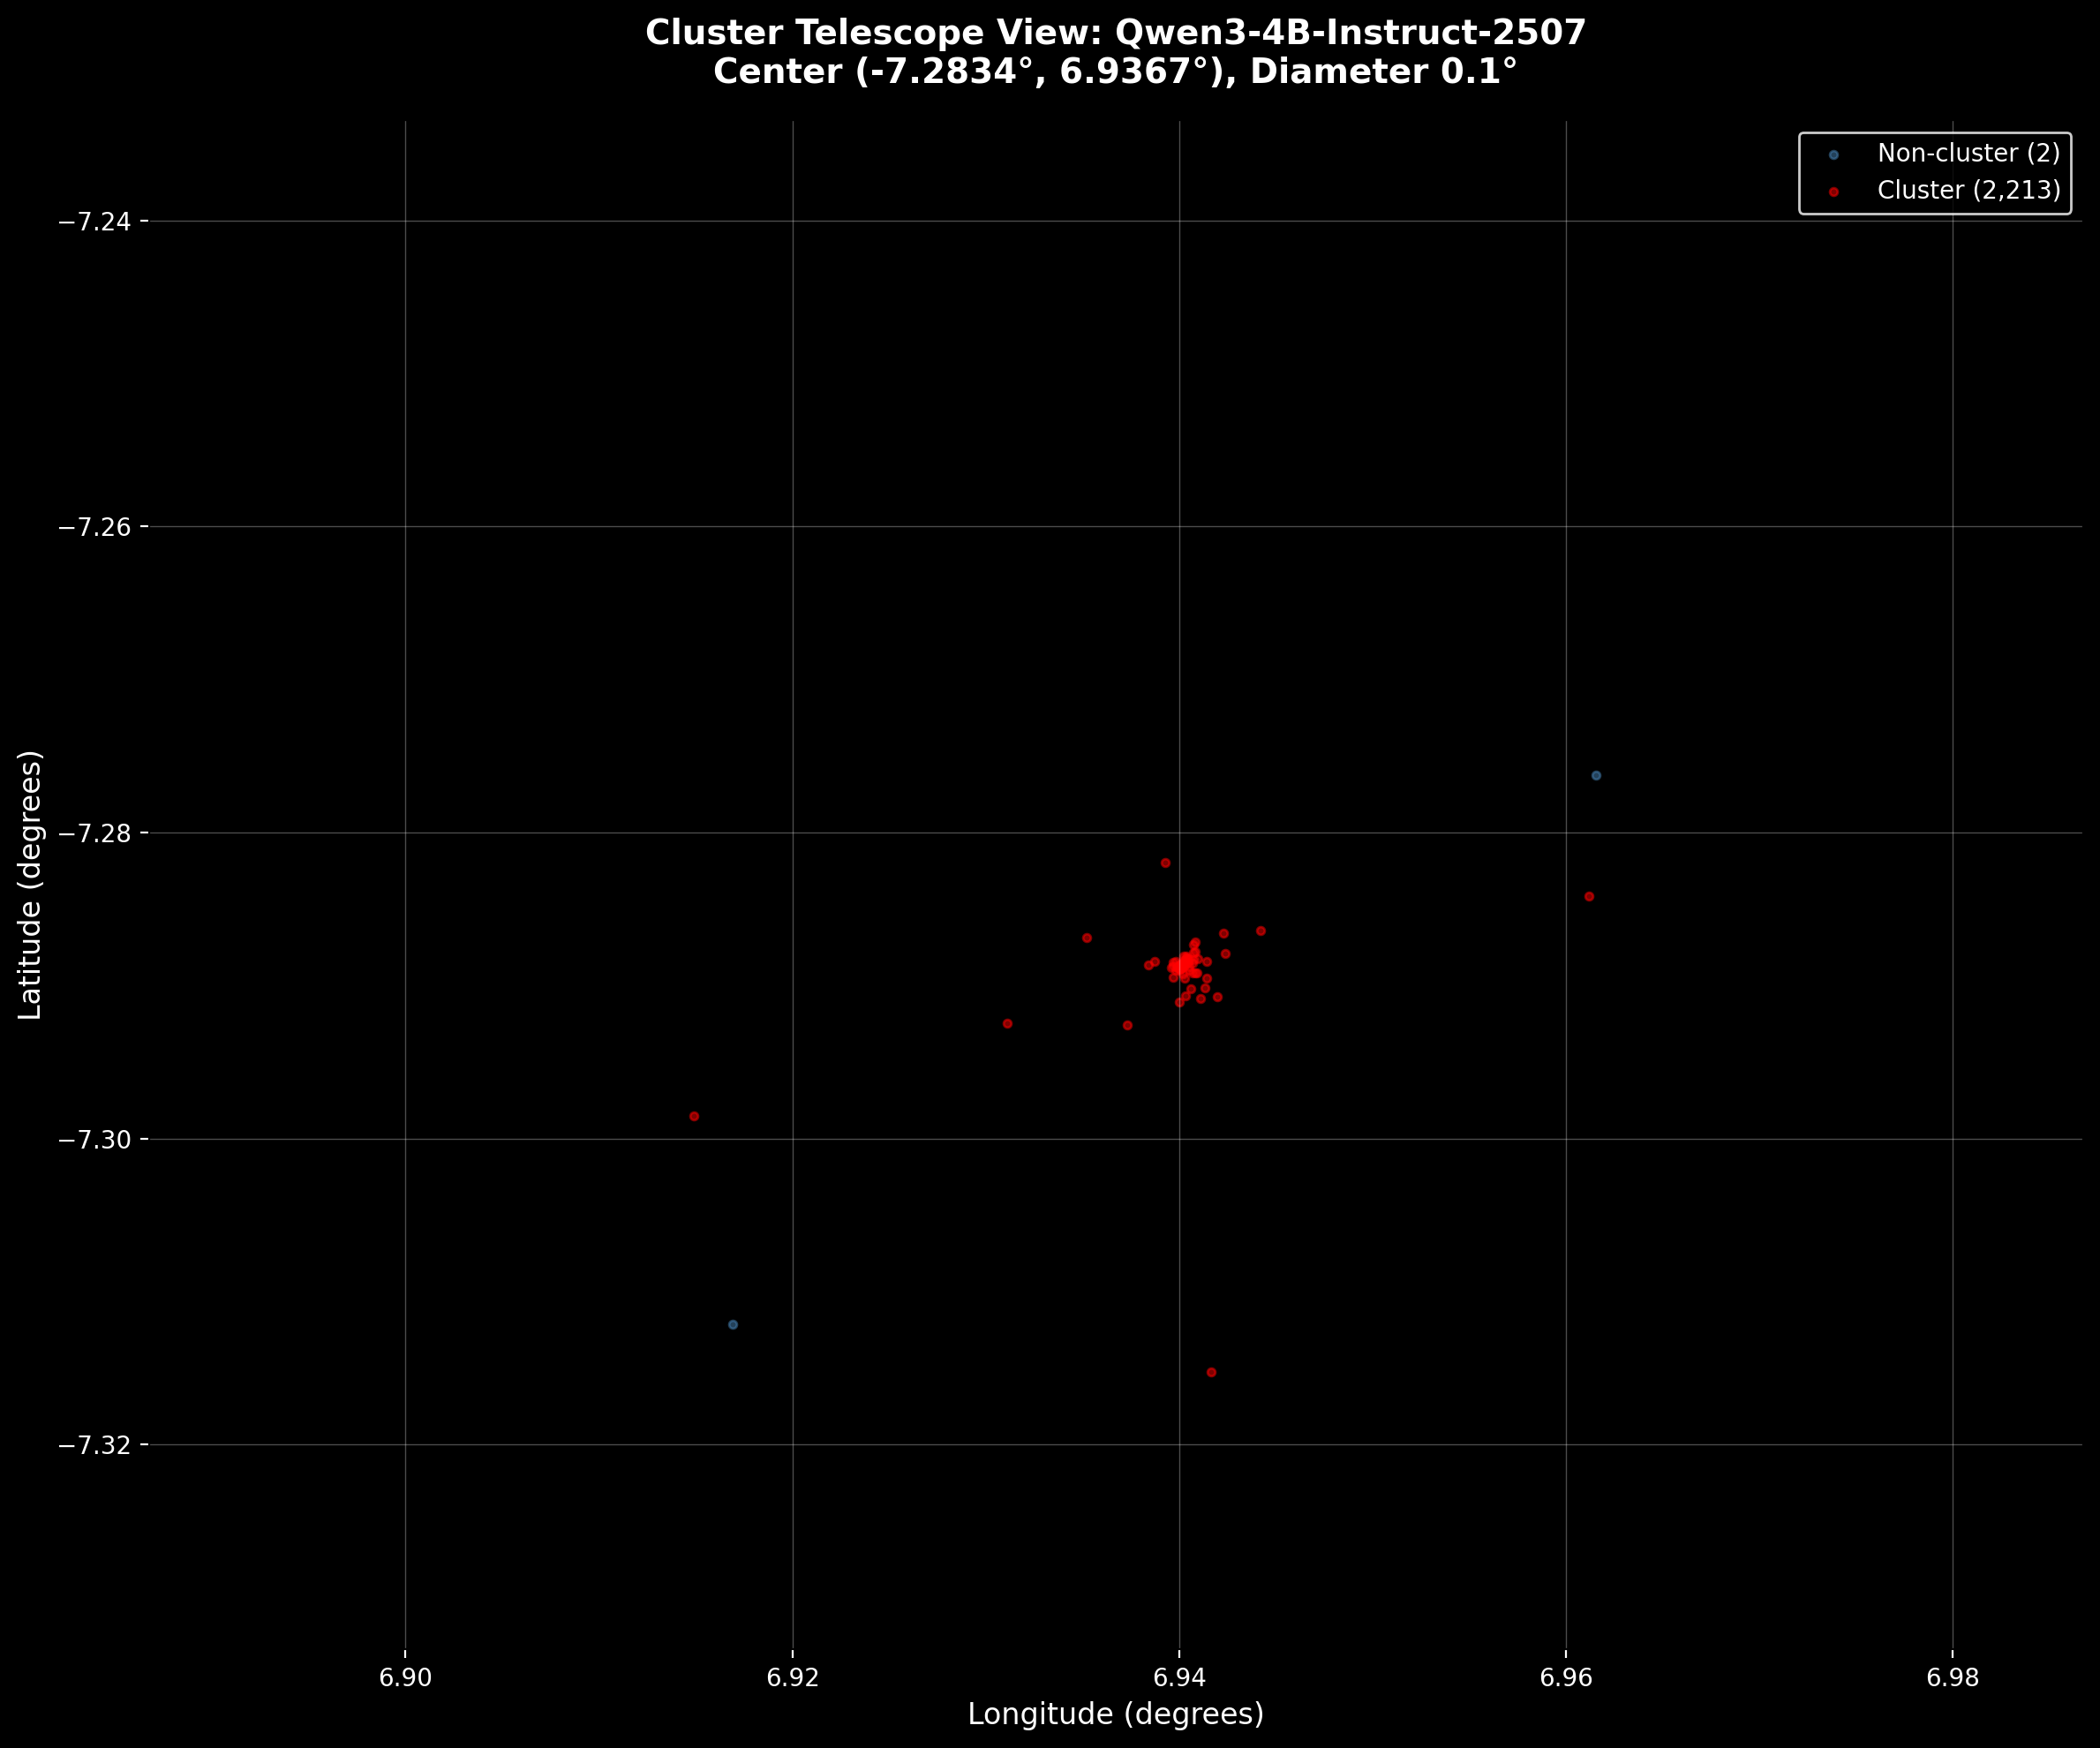

✓ Scatter plot complete


In [71]:
print("\nCreating two-color scatter plot...\n")

# Extract coordinates
lat_cluster = lat_deg[cluster_in_fov].numpy()
lon_cluster = lon_deg[cluster_in_fov].numpy()
lat_non_cluster = lat_deg[non_cluster_in_fov].numpy()
lon_non_cluster = lon_deg[non_cluster_in_fov].numpy()

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Plot non-cluster tokens first (background)
if n_non_cluster_fov > 0:
    ax.scatter(lon_non_cluster, lat_non_cluster, 
               s=NON_CLUSTER_SIZE, alpha=NON_CLUSTER_ALPHA, 
               c=NON_CLUSTER_COLOR, label=f'Non-cluster ({n_non_cluster_fov:,})',
               rasterized=True)

# Plot cluster tokens on top (foreground)
if n_cluster_fov > 0:
    ax.scatter(lon_cluster, lat_cluster,
               s=CLUSTER_SIZE, alpha=CLUSTER_ALPHA,
               c=CLUSTER_COLOR, label=f'Cluster ({n_cluster_fov:,})',
               rasterized=True)

# Formatting
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.set_xlabel('Longitude (degrees)', color='white', fontsize=12)
ax.set_ylabel('Latitude (degrees)', color='white', fontsize=12)
ax.set_title(f'Cluster Telescope View: {MODEL_NAME}\n'
             f'Center ({centroid_lat:.4f}°, {centroid_lon:.4f}°), '
             f'Diameter {ANGULAR_DIAMETER}°',
             color='white', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
ax.tick_params(colors='white')
ax.legend(loc='upper right', fontsize=10, facecolor='black', 
          edgecolor='white', labelcolor='white')

plt.tight_layout()
plt.show()

print("✓ Scatter plot complete")

## Density Heatmap: Cluster Only

Show the fine-scale density structure of the cluster at sub-bfloat16 resolution.


Creating cluster density heatmap...

Density grid: 1 × 1 bins
  Angular bin size: 1°

Applied Gaussian smoothing (σ = 0.5)
Density statistics:
  Max density: 2213.0 tokens per bin
  Mean density: 2213.0 tokens per bin



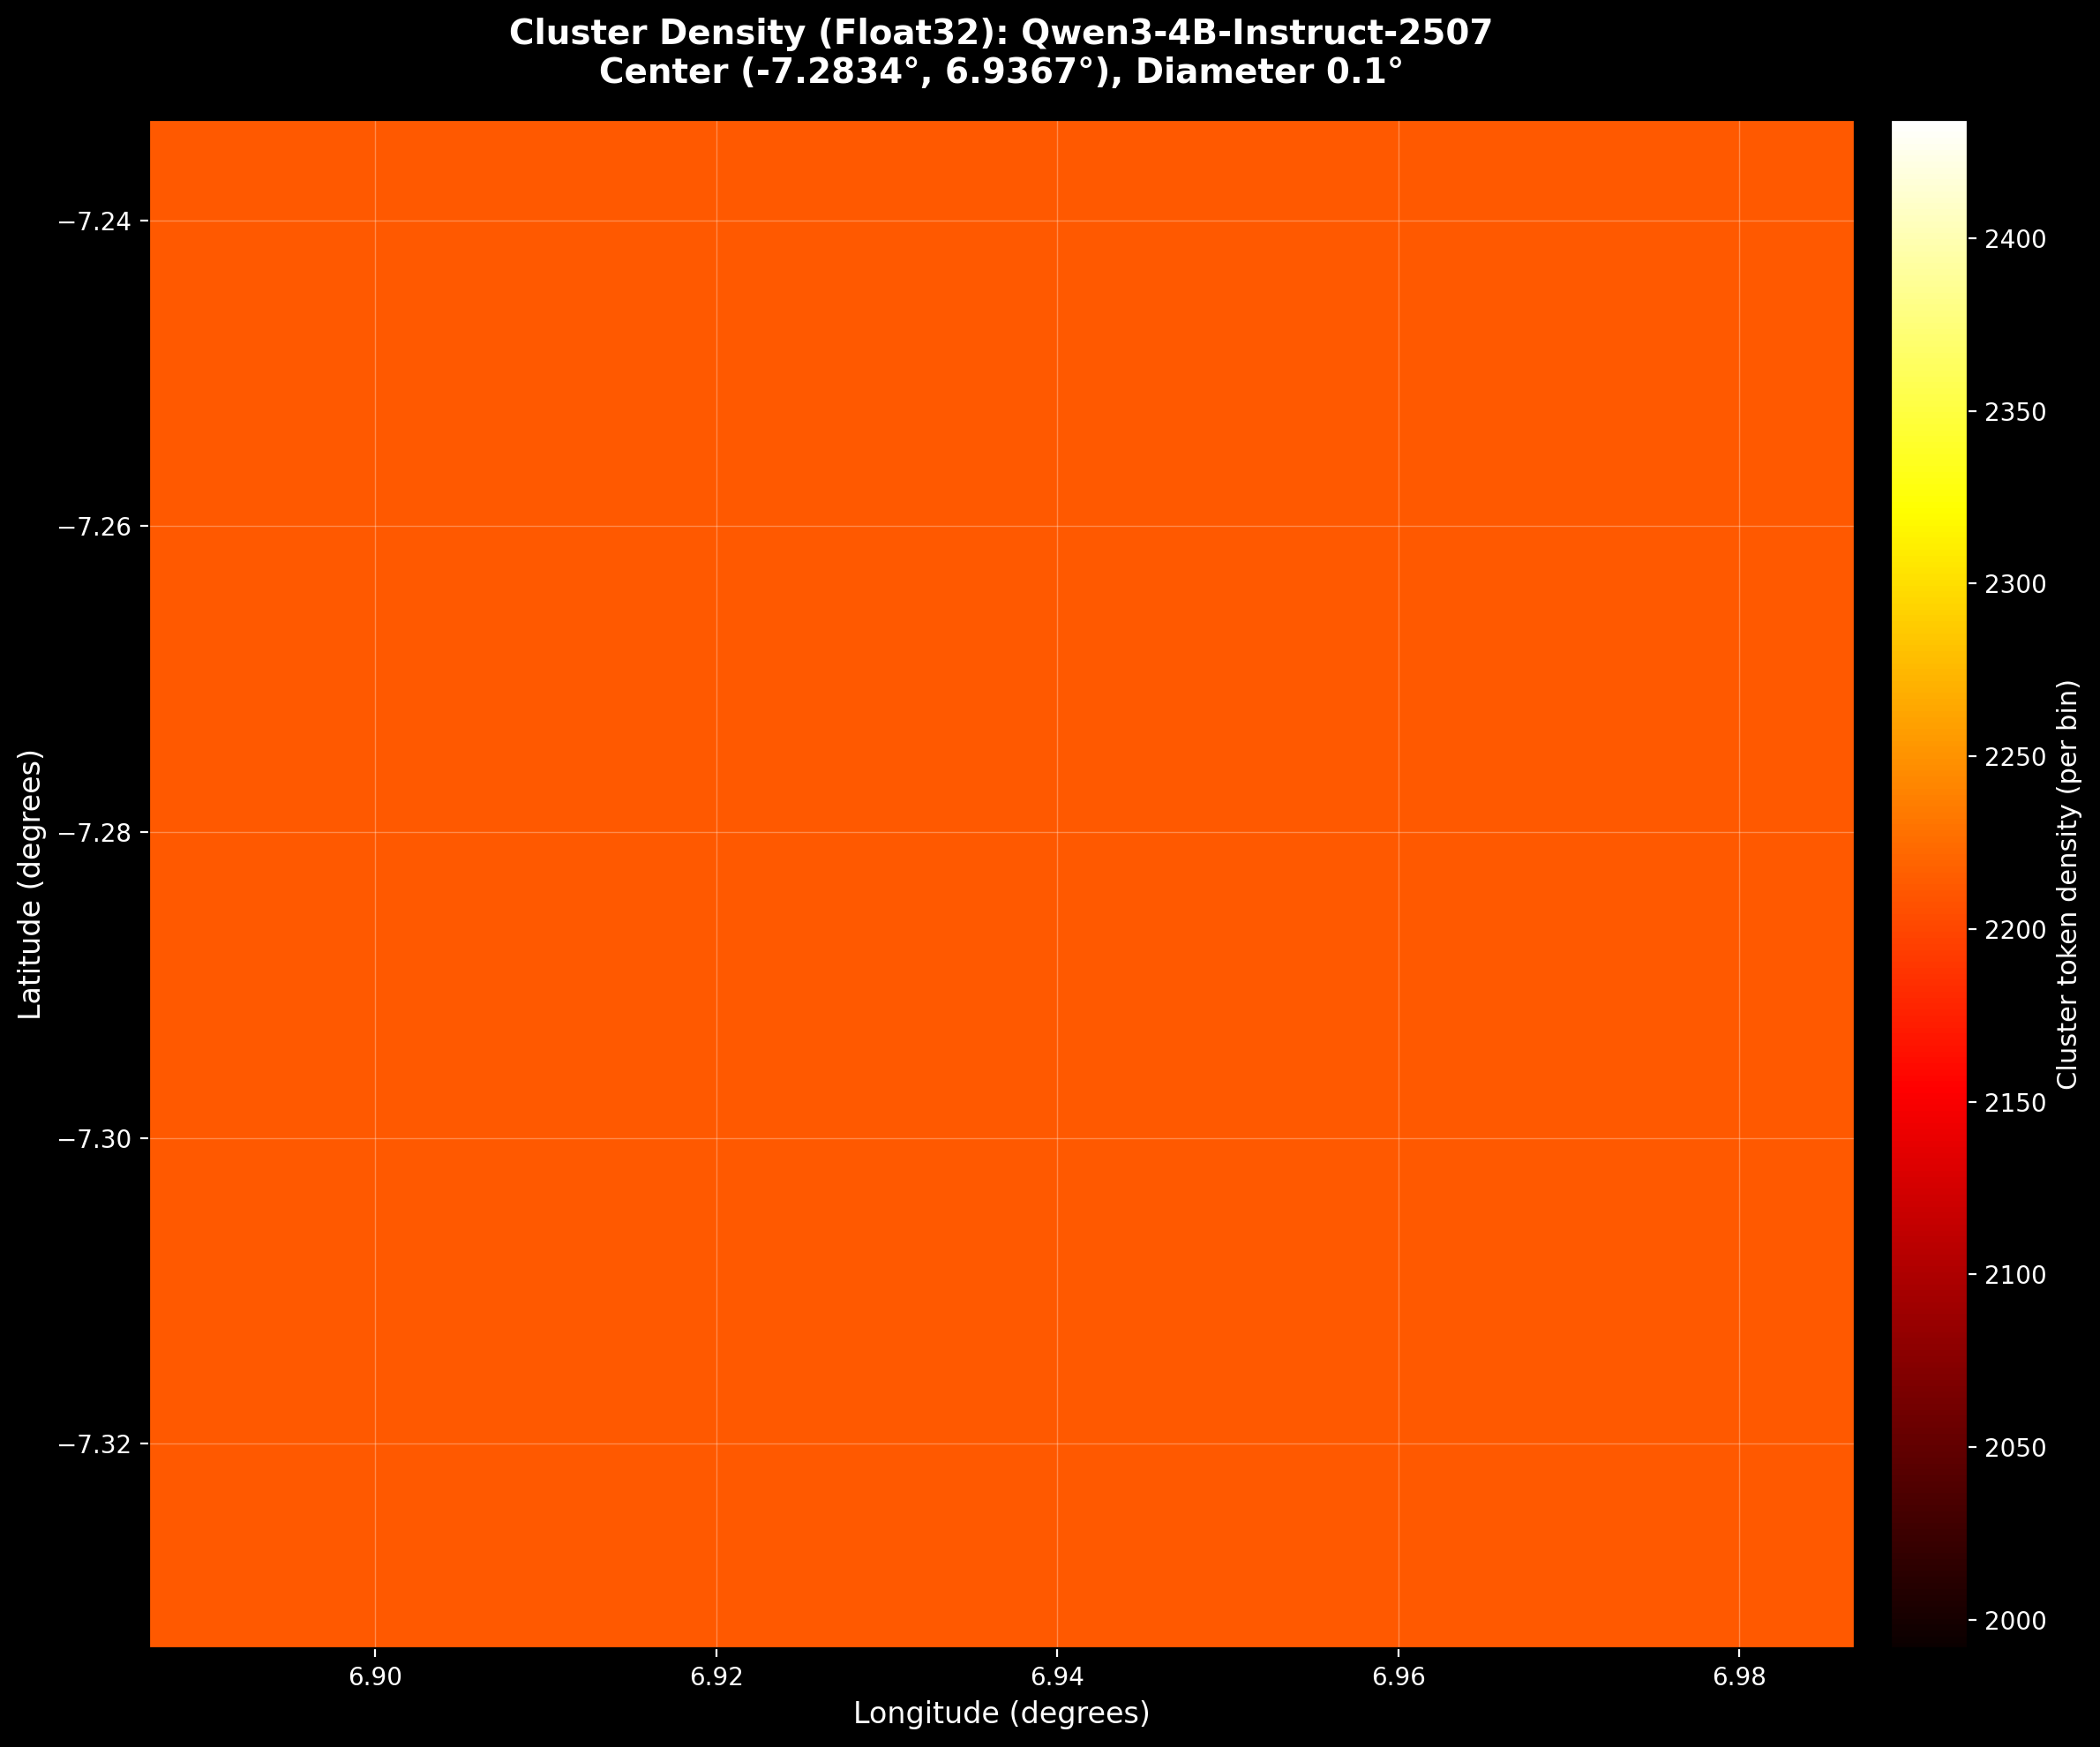

✓ Density heatmap complete


In [72]:
print("\nCreating cluster density heatmap...\n")

if n_cluster_fov > 0:
    # Compute bin counts
    n_lon_bins = int(np.ceil(ANGULAR_DIAMETER / ANGULAR_BIN_SIZE))
    n_lat_bins = int(np.ceil(ANGULAR_DIAMETER / ANGULAR_BIN_SIZE))
    
    print(f"Density grid: {n_lon_bins} × {n_lat_bins} bins")
    print(f"  Angular bin size: {ANGULAR_BIN_SIZE}°")
    print()
    
    # Create 2D histogram (cluster only)
    hist, lon_edges, lat_edges = np.histogram2d(
        lon_cluster, lat_cluster,
        bins=[n_lon_bins, n_lat_bins],
        range=[[lon_min, lon_max], [lat_min, lat_max]]
    )
    
    # Apply smoothing
    if DENSITY_SMOOTH is not None:
        hist = gaussian_filter(hist, sigma=DENSITY_SMOOTH)
        print(f"Applied Gaussian smoothing (σ = {DENSITY_SMOOTH})")
    
    print(f"Density statistics:")
    print(f"  Max density: {hist.max():.1f} tokens per bin")
    print(f"  Mean density: {hist.mean():.1f} tokens per bin")
    print()
    
    # Create figure
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    
    # Plot heatmap
    extent = [lon_min, lon_max, lat_min, lat_max]
    im = ax.imshow(hist.T, origin='lower', extent=extent,
                   cmap=DENSITY_COLORMAP, aspect='auto',
                   interpolation='nearest', rasterized=True)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, pad=0.02, fraction=0.046)
    cbar.set_label('Cluster token density (per bin)', color='white', fontsize=11)
    cbar.ax.tick_params(colors='white')
    
    # Formatting
    ax.set_xlabel('Longitude (degrees)', color='white', fontsize=12)
    ax.set_ylabel('Latitude (degrees)', color='white', fontsize=12)
    ax.set_title(f'Cluster Density (Float32): {MODEL_NAME}\n'
                 f'Center ({centroid_lat:.4f}°, {centroid_lon:.4f}°), '
                 f'Diameter {ANGULAR_DIAMETER}°',
                 color='white', fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
    ax.tick_params(colors='white')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Density heatmap complete")
else:
    print("No cluster tokens in field of view - skipping density plot")

## Summary

This telescope view reveals the internal structure of the cluster at float32 precision:
- Cluster tokens (red) are the 2,251 tokens indistinguishable at bfloat16
- Non-cluster tokens (blue) are nearby tokens in embedding space
- The density heatmap shows sub-bfloat16 structure invisible to the model

Adjust `ANGULAR_DIAMETER` to zoom in/out and explore different scales.